# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

In [3]:
#looking at the number of attributes and size of the data
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())

(364171, 10)
positive    307061
negative     57110
Name: Score, dtype: int64


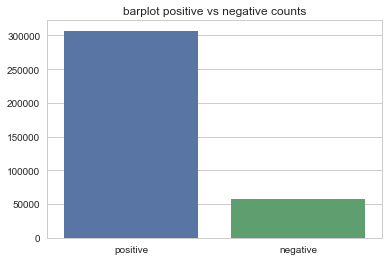

In [18]:
#final['Score'].value_counts().index
#final['Score'].value_counts().values

plt.title('barplot positive vs negative counts')
sns.set(style='whitegrid')
sns.barplot(final['Score'].value_counts().index,final['Score'].value_counts().values)

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
import re
import string
from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/]',r' ',cleantext)
    return  cleantext    

print('************************************')

print(sno.stem('tasty'))

************************************
tasti


In [30]:
#Working on a small randomly sampled subset of the whole dataset owing to limitations of machine configuration

from sklearn.utils import shuffle

pos=final[final.Score=='positive'].sample(n=1000)

neg=final[final.Score=='negative'].sample(n=1000)

all_dfs = [pos,neg]

#merge positive and negative sample dataframes
sample = pd.concat(all_dfs).reset_index(drop=True)

sample = shuffle(sample)

print(sample.shape)

sample.head()

(2000, 10)
negative


In [31]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sample['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (sample['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(sample['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [32]:
#adding a column named CleanedText which displays the data after pre-processing of the review 
sample['CleanedText']=final_string

In [33]:
sample['CleanedText'].head()

1067    b'realli excit tri salt vinegar alway favorit ...
1803    b'drink keemun congou tea year first tast keem...
153     b'vet first suggest tri improv cuz breath say ...
367     b'may perfect sell jelli belli take away tast ...
1955    b'love artichok heart heart palm soon open cou...
Name: CleanedText, dtype: object

In [17]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
sample.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# [7.2.2] Bag of Words (BoW)

In [46]:
#BoW using scikit learn

count_vect = CountVectorizer() #implemented in scikit learn

#apply on cleaned review text column  of sample dataset

bag_of_words = count_vect.fit_transform(sample['CleanedText'].values) 

print(bag_of_words.shape)

#bag_of_words is of type scipy.sparse.csr.csr_matrix; t-SNE cannot be applied directly on sparse data

print(type(bag_of_words))
#check initial 100 features
print(count_vect.get_feature_names()[:99])


(2000, 6629)
<class 'scipy.sparse.csr.csr_matrix'>
['aafco', 'abdomen', 'abdomin', 'abel', 'abil', 'abl', 'abottl', 'abound', 'abrupt', 'absent', 'absentmind', 'absolut', 'absolutley', 'absorb', 'absorpt', 'absout', 'abt', 'abysm', 'academi', 'acai', 'accent', 'accept', 'accid', 'accident', 'accommod', 'accomod', 'accompani', 'accomplish', 'accord', 'account', 'accross', 'accumult', 'accur', 'accus', 'accustom', 'acerola', 'acet', 'ach', 'achiev', 'acid', 'acidi', 'acidifi', 'acknowledg', 'acm', 'acquir', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'adher', 'adjust', 'administ', 'admit', 'admitt', 'ado', 'ador', 'adrenalin', 'adult', 'advanc', 'advantag', 'adventur', 'advers', 'advert', 'advertis', 'advic', 'advis', 'aerat', 'aerogarden', 'aesthet', 'affair', 'affect', 'affili', 'afforadab', 'afford', 'afghanistan', 'aforement', 'afraid', 'africa', 'african', 'afternoon', 'afteroon', 'aftertas', 'aftertast

In [54]:
#initial 5 features of bag of words
print(count_vect.get_feature_names()[:4])
#print(bag_of_words[0])

['aafco', 'abdomen', 'abdomin', 'abel']


In [47]:
#dimensionality reduction using TruncatedSVD for the bag of words sparse data

from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=2000) #No of components as total dimensions
svd_modeled_data = svd_model.fit_transform(bag_of_words)

#check the amount of variance preserved after TruncatedSVD

print(svd_model.explained_variance_ratio_[:].sum()) #99.99 % variance preserved after SVD

0.9999999999999998


In [49]:
print(type(svd_modeled_data))
print(bag_of_words.shape)
print(svd_modeled_data.shape)

<class 'numpy.ndarray'>
(2000, 6629)
(2000, 2000)


In [55]:
#visualize bag of words using t-SNE with perplexity 30
#first, apply t-SNE on o/p of SVD process

from sklearn.manifold import TSNE

model = TSNE(n_components=2,random_state=0,perplexity=30)

lower_dim_data = model.fit_transform(svd_modeled_data)


(2000, 2)


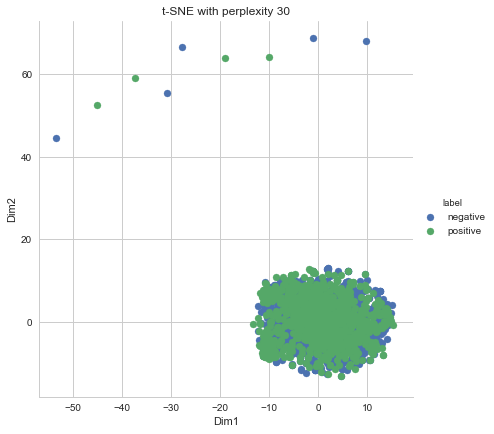

In [56]:
print(lower_dim_data.shape)

final_data = np.concatenate((lower_dim_data,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 30")
plt.show()

In [57]:
#visualize using t-SNE with perplexity 40
#first, apply t-SNE on o/p of SVD process

from sklearn.manifold import TSNE

model = TSNE(n_components=2,random_state=0,perplexity=40)

lower_dim_data = model.fit_transform(svd_modeled_data)

(2000, 2)


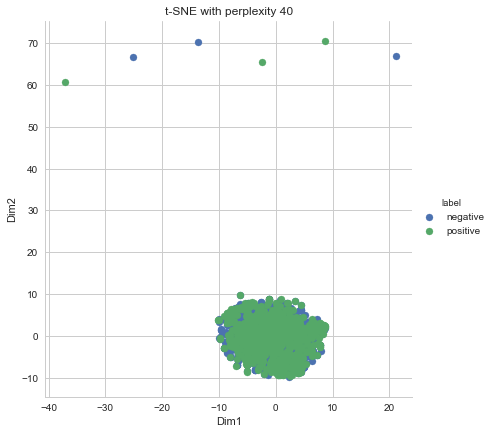

In [58]:
print(lower_dim_data.shape)

final_data = np.concatenate((lower_dim_data,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 40")
plt.show()

In [59]:
#Applying tf-Idf

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()

tfidf_vec = tfidf_model.fit_transform(sample['CleanedText'].values)

In [62]:
print(tfidf_vec.shape)
print(type(tfidf_vec))
#initial few features of tf-idf
print(tfidf_model.get_feature_names()[:5])

(2000, 6629)
<class 'scipy.sparse.csr.csr_matrix'>
['aafco', 'abdomen', 'abdomin', 'abel', 'abil']


In [63]:
#Since we cannot apply t-SNE directly on sparse data, we will use truncateSVD on the o/p of TfidfVectorizer

tfidf_svd = TruncatedSVD(n_components=2000) #No of components as total dimensions

svd_modeled_tfidf = tfidf_svd.fit_transform(tfidf_vec)

#check the amount of variance preserved after SVD
print(tfidf_svd.explained_variance_ratio_[:].sum())


1.0000000000000004


In [64]:
#apply t-SNE with perplexity 30 to SVD output data

tfidf_tsne_model = TSNE(n_components=2,random_state=0,perplexity=30)

lower_dim_tfidf  = tfidf_tsne_model.fit_transform(svd_modeled_tfidf)

#The dimension has been reduced to 2
print(svd_modeled_tfidf.shape)
print(lower_dim_tfidf.shape)

(2000, 2000)
(2000, 2)


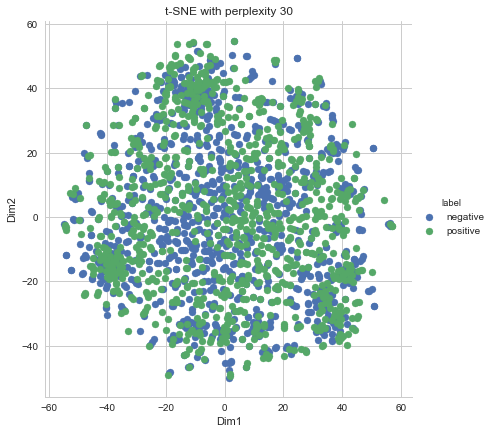

In [65]:
#plot the t-SNE data

tsne_tfidf = np.concatenate((lower_dim_tfidf,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df_tfidf = pd.DataFrame(data=tsne_tfidf,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df_tfidf,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 30")
plt.show()

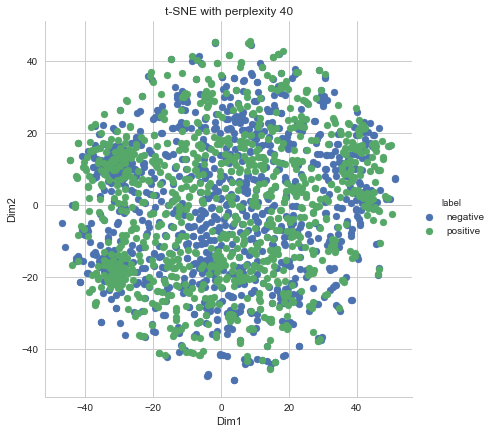

In [66]:
#repeat t-SNE with perplixity 40

tfidf_tsne_model = TSNE(n_components=2,random_state=0,perplexity=40)

lower_dim_tfidf  = tfidf_tsne_model.fit_transform(svd_modeled_tfidf)

tsne_tfidf = np.concatenate((lower_dim_tfidf,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df_tfidf = pd.DataFrame(data=tsne_tfidf,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df_tfidf,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 40")
plt.show()

In [75]:
# using word2vec model by google

from nltk.tokenize import word_tokenize

input_list_of_list = [ [w for w in word_tokenize(clean_rev) if w not in stop] for clean_rev in [cleansentence(review) for review in sample['Text'].values]]

#check the first list of tokens
input_list_of_list[0]

['I',
 'really',
 'excited',
 'try',
 'salt',
 '&',
 'vinegar',
 'always',
 'favorite',
 'flavor',
 'I',
 'say',
 'taste',
 'spot',
 'texture',
 'off-putting',
 'I',
 'could',
 'get',
 'used',
 'somewhat',
 'liked',
 'stale',
 'cracker',
 'feel',
 'left',
 'awful',
 'coating',
 'mouth',
 'It',
 'akin',
 'plain',
 'Smartfood',
 'popcorn',
 'Im',
 'guessing',
 'something',
 'production',
 'popped',
 'foods',
 'Not',
 'bad',
 'something',
 'Id',
 'try',
 'However',
 'two',
 'positives',
 'significantly',
 'cheaper',
 'Amazon',
 'almost',
 '$',
 '1',
 '50',
 'per',
 'bag',
 'less',
 'fat',
 'content',
 'baked',
 'If',
 'youre',
 'fan',
 'great',
 'choice']

In [80]:
import gensim

w2v_model = gensim.models.Word2Vec(input_list_of_list,min_count=5,size=50)


In [81]:
w2v_voc = w2v_model.wv.vocab
#size of vocabulary
print(len(w2v_voc))

#check words similar to good in the corpus as per word2vec model
w2v_model.wv.most_similar("good")

2796


[('great', 0.999845564365387),
 ('Its', 0.9998397827148438),
 ('strong', 0.999813437461853),
 ('drink', 0.9998090863227844),
 ('also', 0.9998042583465576),
 ('flavor', 0.9997972249984741),
 ('sweet', 0.9997940063476562),
 ('This', 0.9997854828834534),
 ('stuff', 0.9997729659080505),
 ('roast', 0.9997624158859253)]

In [85]:
avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in input_list_of_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model
    sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

print(len(avg_wt_vecs)) #2000 vectors for 2000 reviews
print(len(avg_wt_vecs[0])) # each vector has 50 components

2000
50


In [86]:
#visualize word2vec using t-SNE with perplexity 30

tsne_model = TSNE(perplexity=30, n_components=2)

after_tsne = tsne_model.fit_transform(avg_wt_vecs)


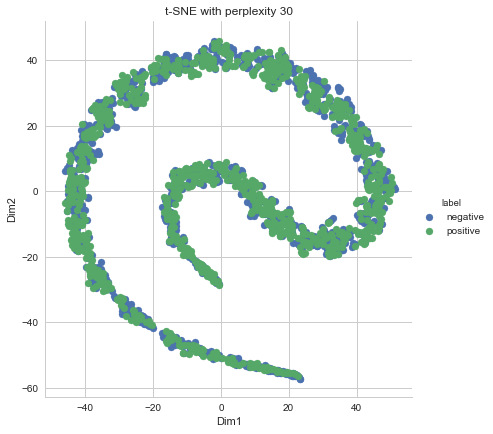

In [88]:
tsne_avg_w2v = np.concatenate((after_tsne,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df_w2v = pd.DataFrame(data=tsne_avg_w2v,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df_w2v,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 30")
plt.show()

In [89]:
#repeat t-SNE with perplexity 40

tsne_model = TSNE(perplexity=40, n_components=2)

after_tsne = tsne_model.fit_transform(avg_wt_vecs)

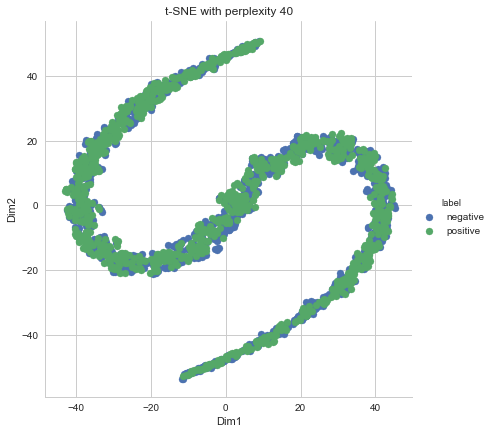

In [90]:
tsne_avg_w2v = np.concatenate((after_tsne,np.array(sample['Score'].values).reshape(2000,1)),axis=1)

tsne_df_w2v = pd.DataFrame(data=tsne_avg_w2v,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_df_w2v,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 40")
plt.show()

In [98]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_model.get_feature_names() # tfidf feature names are nothing but words
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # list if tfidf weighted w2v for each review
row=0;
for sentence in input_list_of_list: # for each review/sentence
    sent_vec = np.zeros(50) #initialize the vector for the sentence with all 50 components as 0
    weight_sum =0; # to store sum of tf-idfs of words in the sentence with a vector in w2v model 
    for word in sentence: # sentence is a list of tokens
        try:
            vec = w2v_model.wv[word] #get the vector for this word            
            tfidf = tfidf_vec[row, tfidf_features.index(word)] # get the tf_idf value of the word;column index of word in tfidf 
                                                               # matrix = index of word in the tfidf feature list
            sent_vec += (vec * tf_idf)  # add each component of w2v vector of the word with tfidf 
                                        # of the word and add to the sentence vector 
            weight_sum += tf_idf        # capture running sum of tf-idf for each word in sentence
        except:
            pass
    
    if (weight_sum == 0):  # to avoid infinity values in case word's tfidf is not found;tfidf ran with stemming & w2v without
        weight_sum = 1
    sent_vec /= weight_sum # each component of sentence vector has been divided by the running sum of tfidf for each 
                           # words in the sentence 
    tfidf_sent_vectors.append(sent_vec)  #append sentence vector to list of vectors
    row += 1

print(len(tfidf_sent_vectors)) #2000 vectors for 2000 reviews
print(len(tfidf_sent_vectors[0])) #each vector has 50 components

2000
50


In [101]:
#visualize tfidf weighted w2v using t-SNE with perplexity 40

tsne_model = TSNE(perplexity=40, n_components=2)

after_tsne = tsne_model.fit_transform(tfidf_sent_vectors)

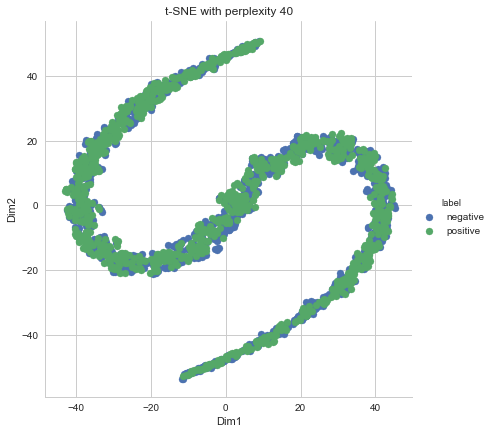

In [102]:
tsne_tfdf_w2v = pd.DataFrame(data=tsne_avg_w2v,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_tfdf_w2v,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 40")
plt.show()

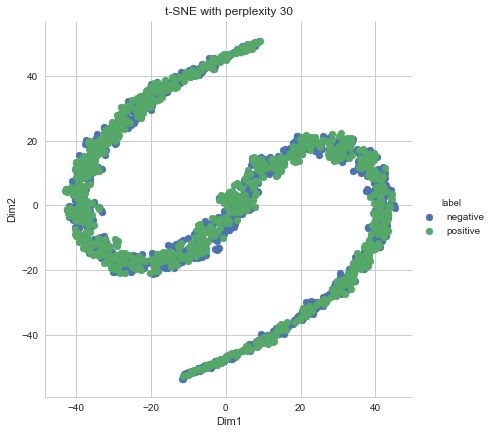

In [103]:
#repeat t-SNE with perplexity 30
tsne_model = TSNE(perplexity=30, n_components=2)

after_tsne = tsne_model.fit_transform(tfidf_sent_vectors)

tsne_tfdf_w2v = pd.DataFrame(data=tsne_avg_w2v,columns=["Dim1","Dim2","label"])

sns.FacetGrid(tsne_tfdf_w2v,hue="label",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("t-SNE with perplexity 30")
plt.show()

# [7.2.5] TF-IDF

In [104]:
w2v_model.wv.similarity('woman', 'man')

0.9958641

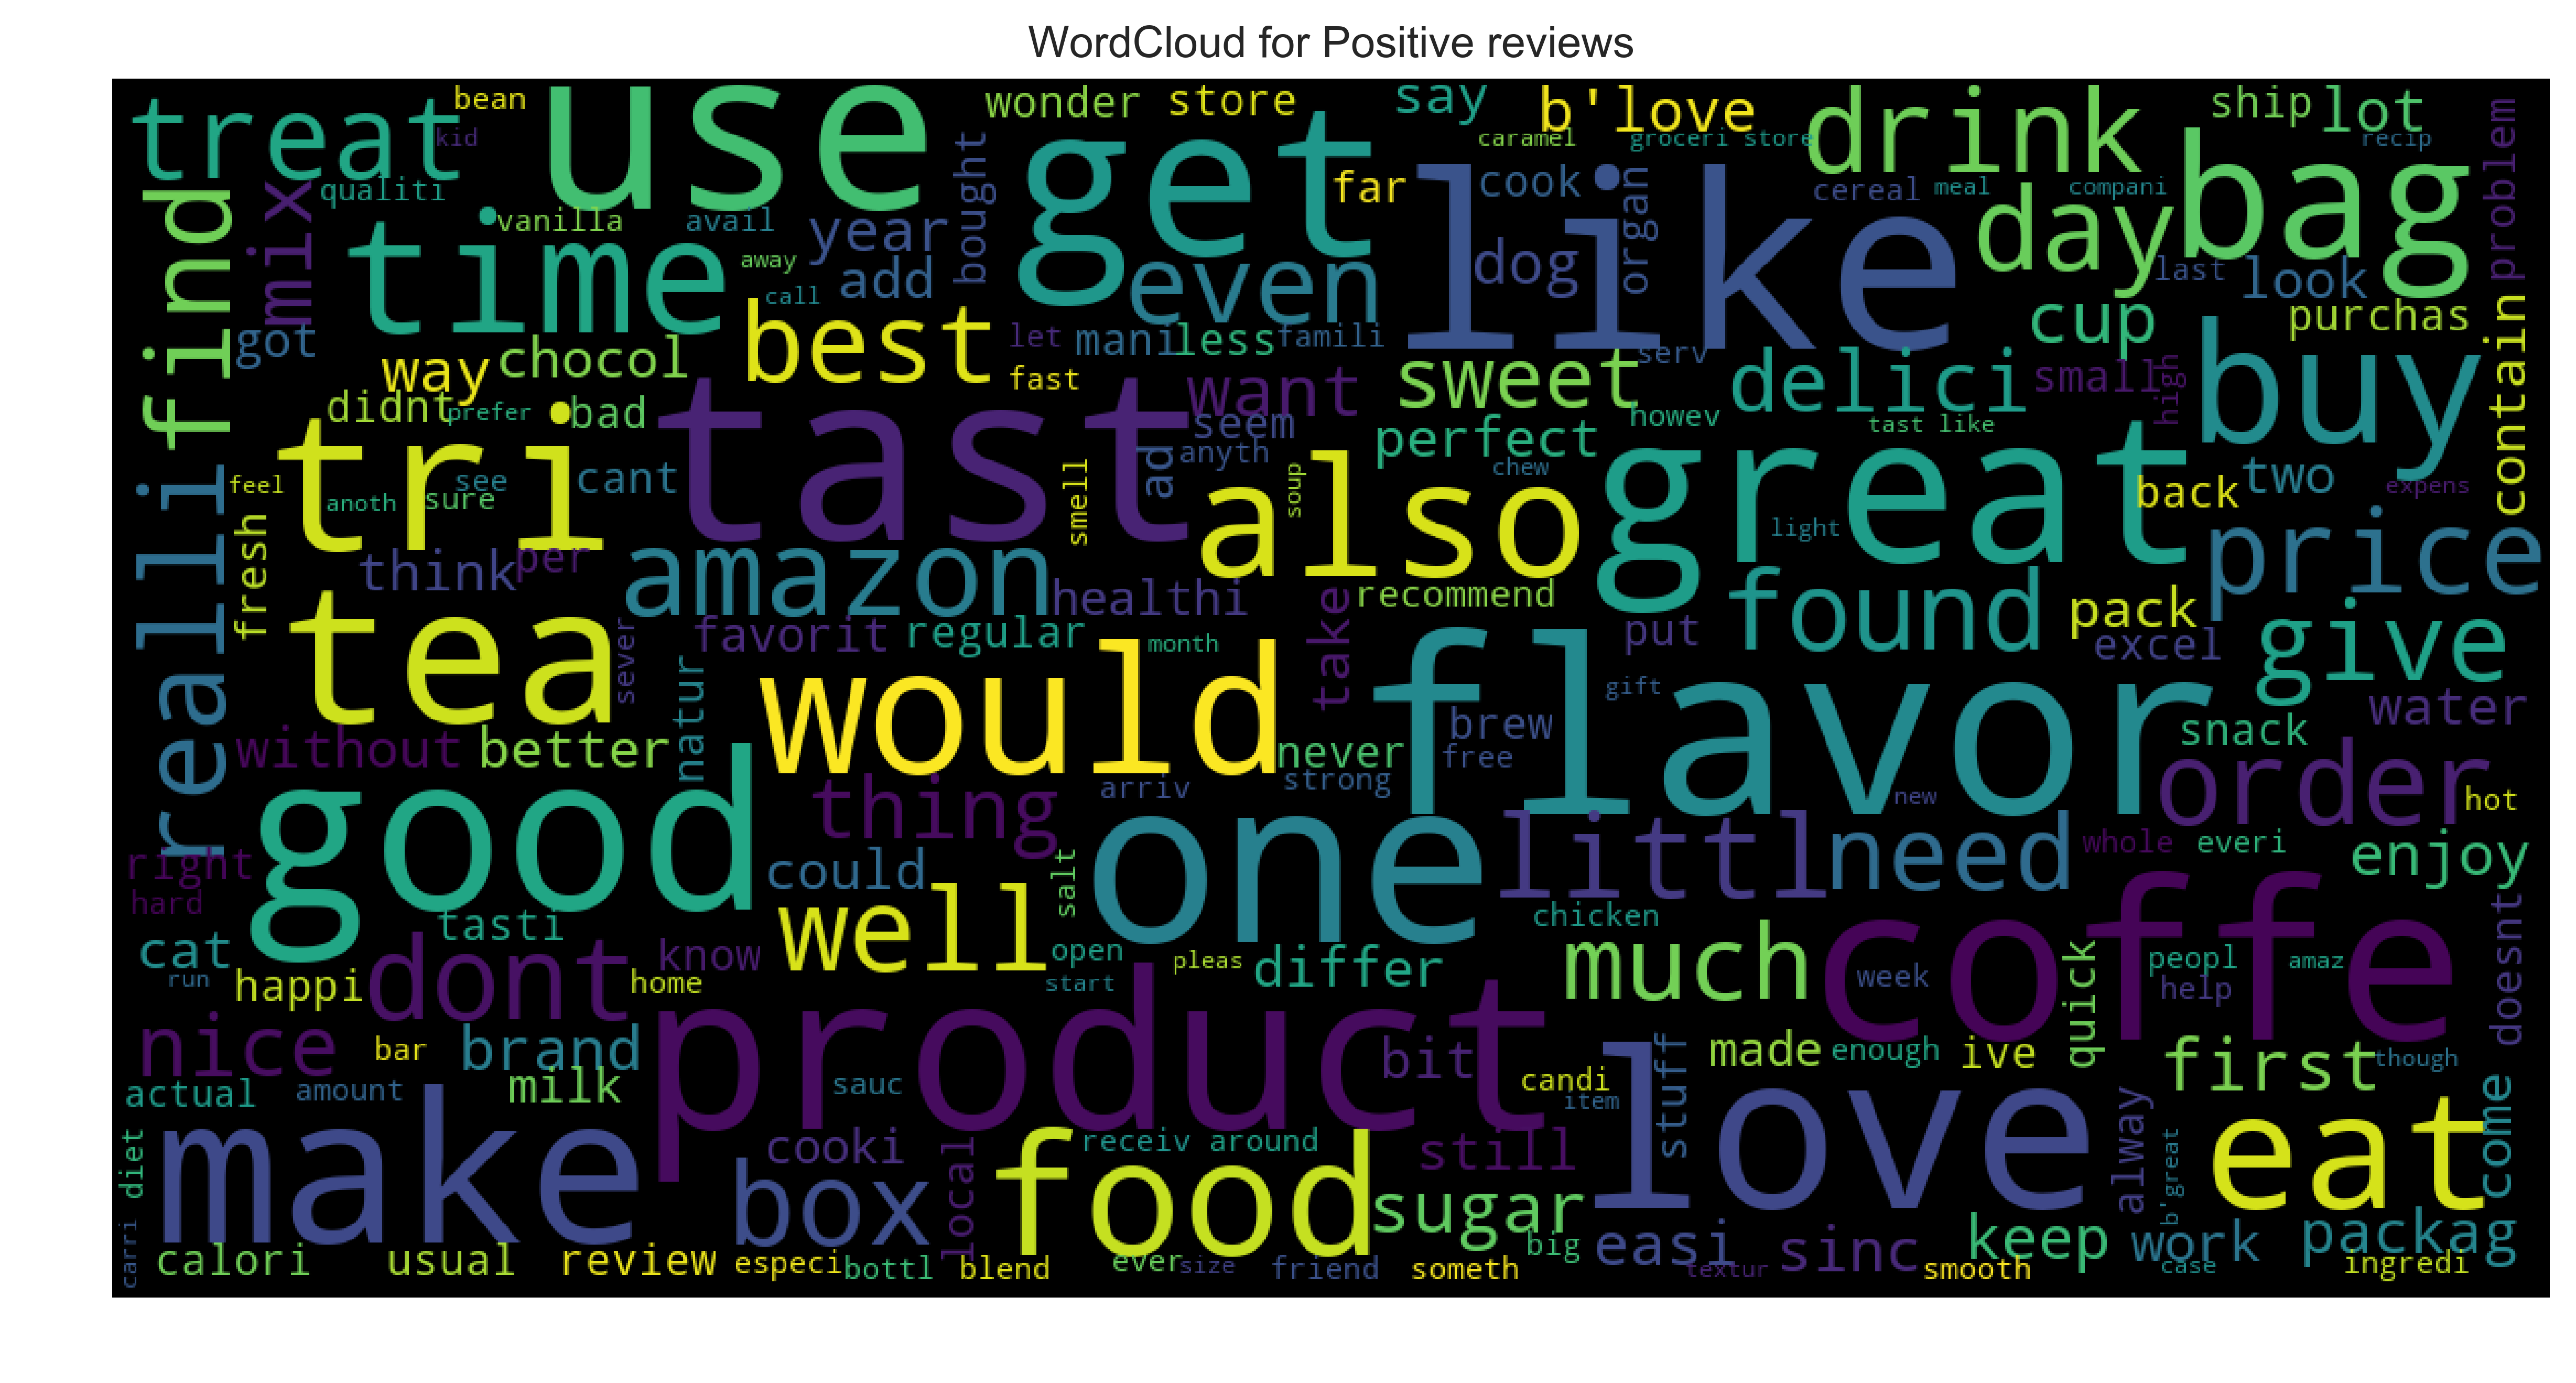

In [129]:
#wordclouds for positive reviews:

from wordcloud import WordCloud

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
plt.figure(num=None, figsize=(12, 10), dpi=500, facecolor='w', edgecolor='k')
#plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=500             #72 
#plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    plt.title('WordCloud for Positive reviews')
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(sample[sample.Score=='positive'].CleanedText.values)

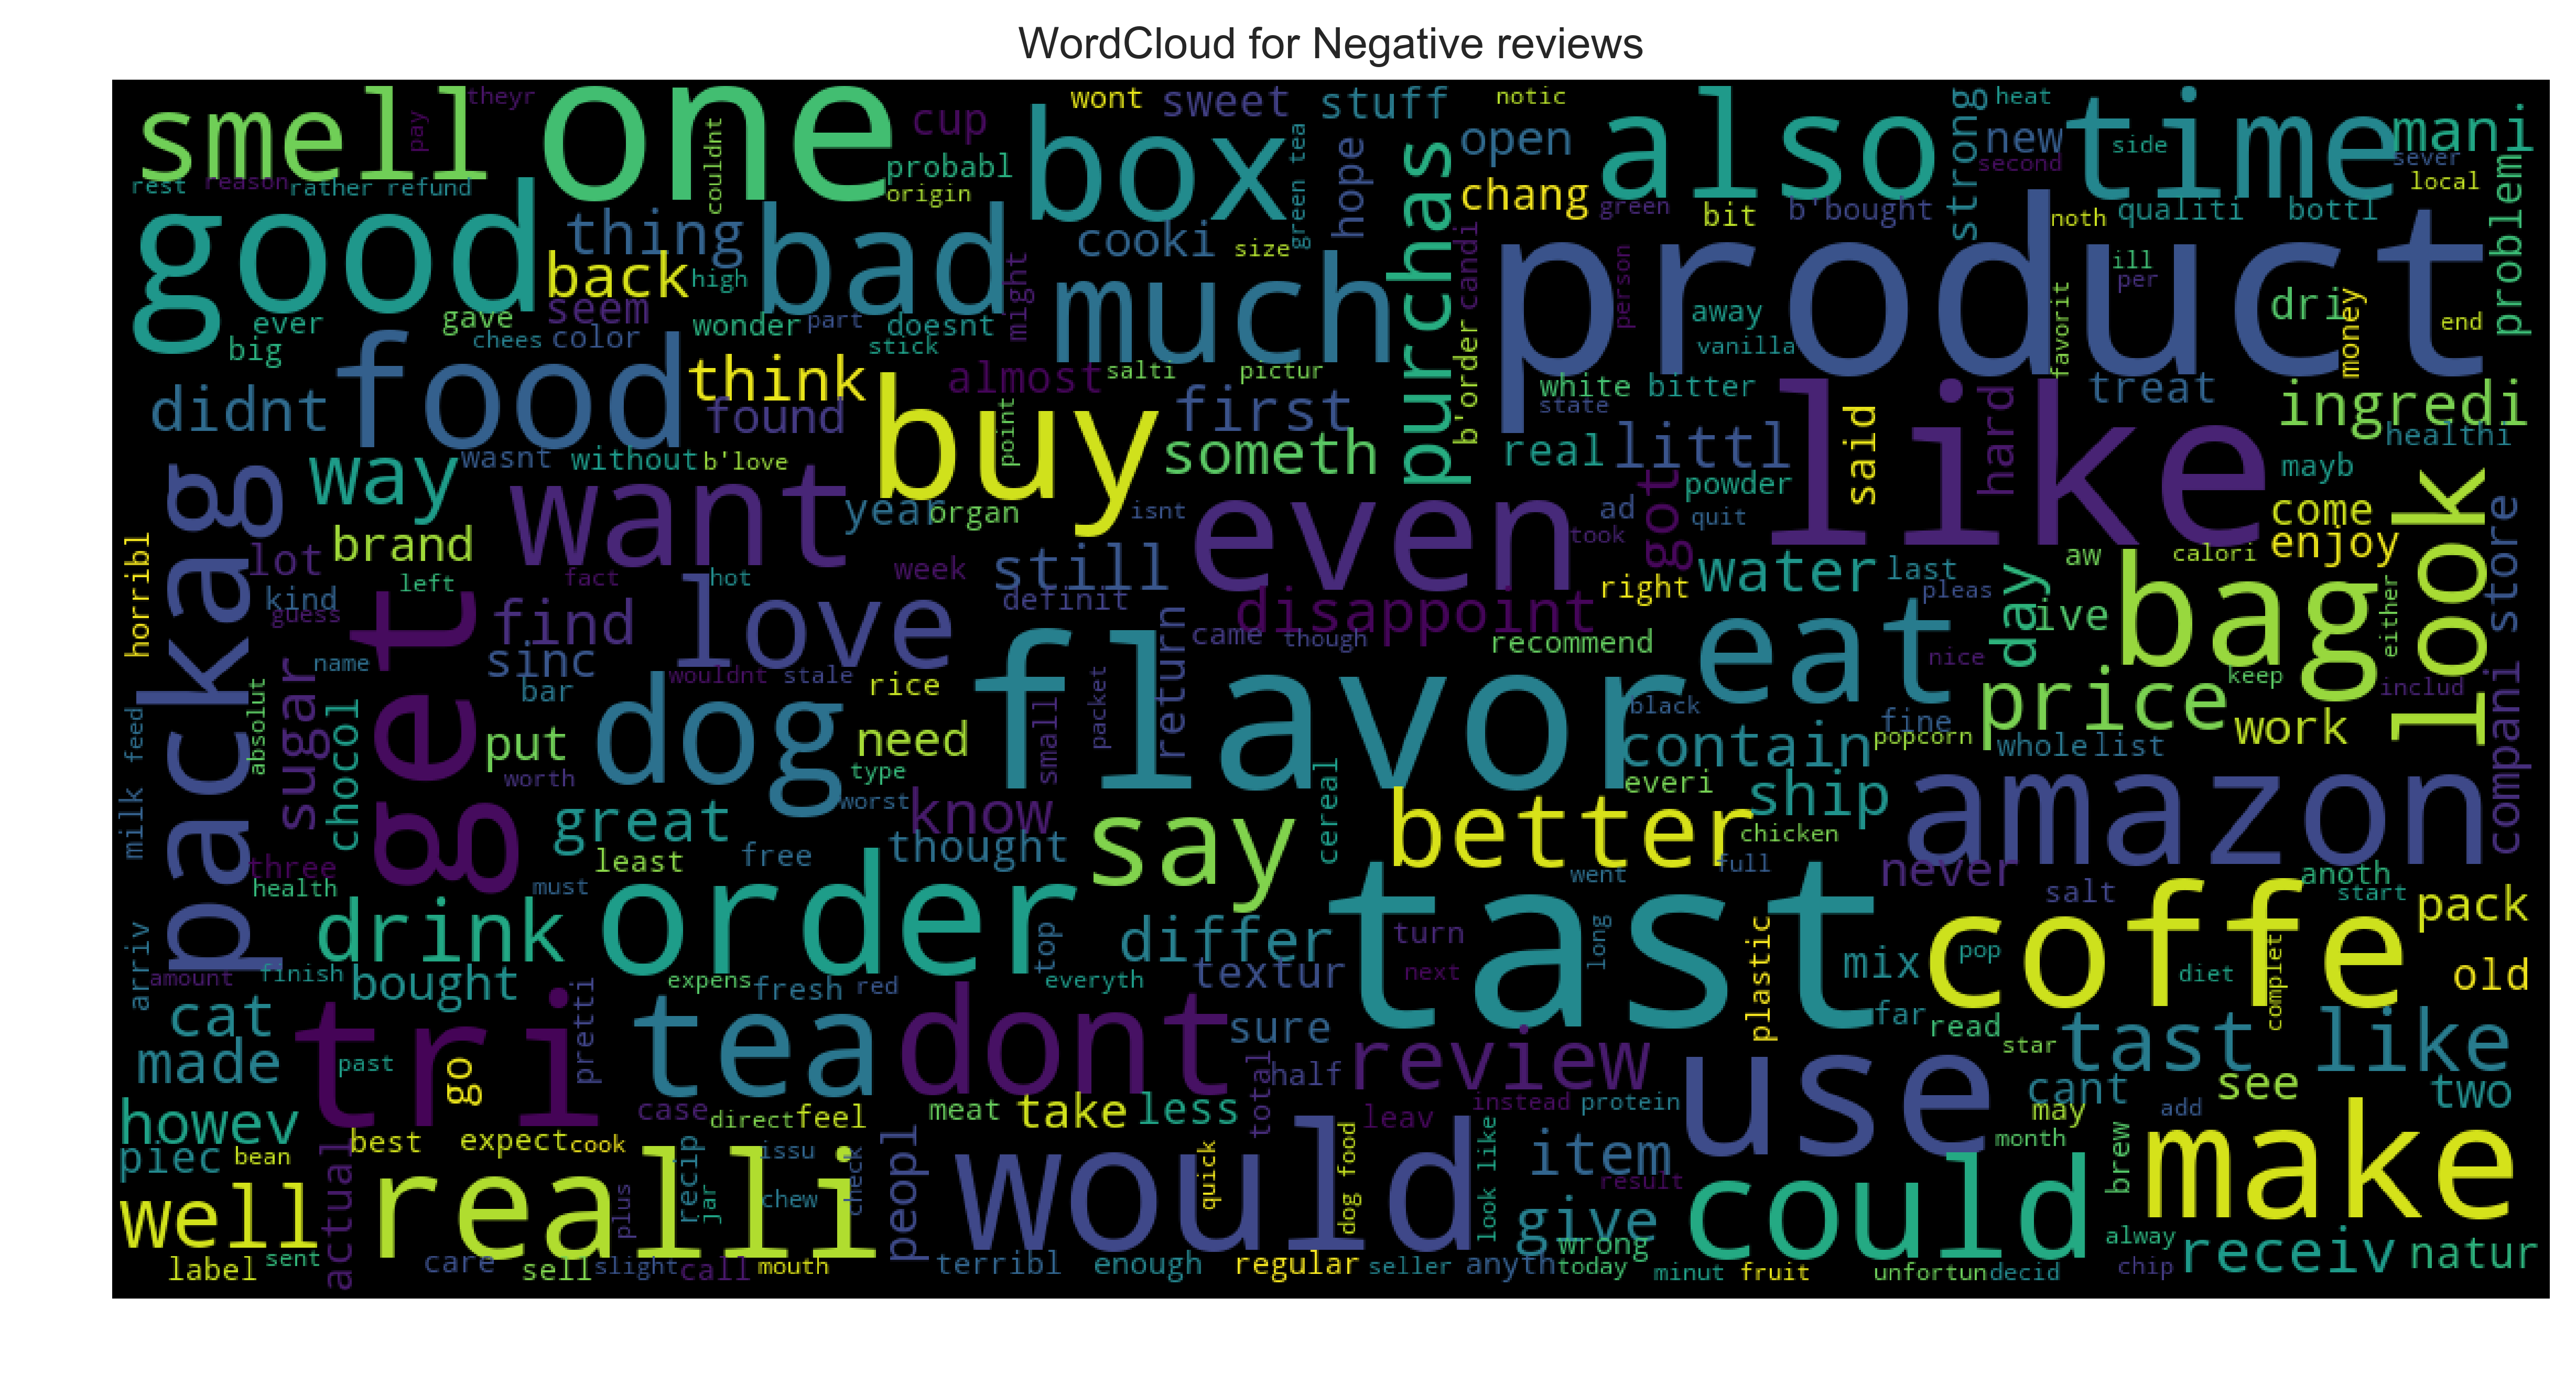

In [128]:
#wordclouds for Negative reviews:

from wordcloud import WordCloud

plt.figure(num=None, figsize=(12, 10), dpi=500, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                 
plt.rcParams['savefig.dpi']=500             
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    plt.title('WordCloud for Negative reviews')
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(sample[sample.Score=='negative'].CleanedText.values)